# Set pyannote constants for an easy life

In [1]:
# speech activity detection model trained on AMI training set
SAD_MODEL = ('/home/geoanton/Repos/pyannote-audio/tutorials/models/speech_activity_detection/train/'
             'AMI.SpeakerDiarization.MixHeadset.train/weights/0280.pt')
# speaker change detection model trained on AMI training set
SCD_MODEL = ('/home/geoanton/Repos/pyannote-audio/tutorials/models/speaker_change_detection/train/'
             'AMI.SpeakerDiarization.MixHeadset.train/weights/0870.pt')
# speaker embedding model trained on VoxCeleb1
EMB_MODEL = ('/home/geoanton/Repos/pyannote-audio/tutorials/models/speaker_embedding/train/'               
             'VoxCeleb.SpeakerVerification.VoxCeleb1.train/weights/2000.pt')

In [2]:
# one can use their own file like this...
test_file = {'uri': 'filename', 'audio': '../data/raw/z-c-feisty.wav'}

# Initialize SAD & SCD sequence labeling models

In [3]:
from pyannote.audio.labeling.extraction import SequenceLabeling
sad = SequenceLabeling(model=SAD_MODEL)
scd = SequenceLabeling(model=SCD_MODEL)

/home/geoanton/anaconda3/envs/pyannote/lib/python3.6/site-packages/pyannote/audio/applications/base.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config_ = yaml.load(fp)


# Speech activity detection
Obtain raw SAD scores (as `pyannote.core.SlidingWindowFeature` instance)

In [4]:
sad_scores = sad(test_file)
# binarize raw SAD scores (as `pyannote.core.Timeline` instance)
# NOTE: both onset/offset values were tuned on AMI dataset.
# you might need to use different values for better results.


In [173]:
from pyannote.audio.signal import Binarize
binarize = Binarize(offset=0.8, onset=0.8, log_scale=True)
speech = binarize.apply(sad_scores, dimension=1)
# iterate over speech segments (as `pyannote.core.Segment` instances)
#for segment in speech:
#    print(segment.start, segment.end)
x = plot_ready(sad_scores)
len(speech)

64

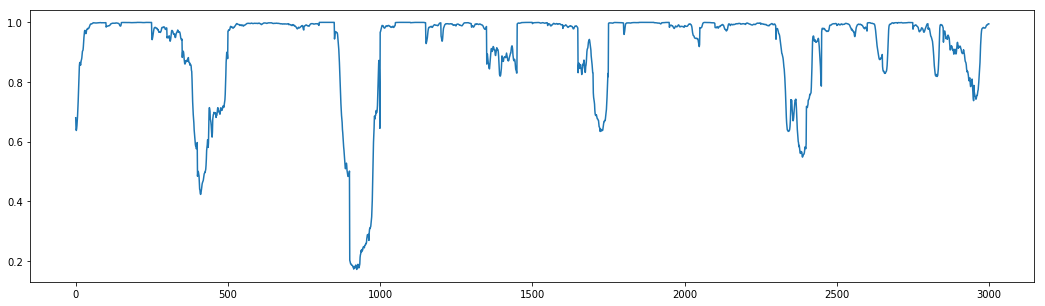

In [174]:
fig,ax = plt.subplots(figsize = (18,5))
ax.plot(x.data[0:3000])

# Speaker change detection

In [175]:
# obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance)
scd_scores = scd(test_file)
# detect peaks and return speaker homogeneous segments 
# (as `pyannote.core.Annotation` instance)
# NOTE: both alpha/min_duration values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.signal import Peak
peak = Peak(alpha=0.08, min_duration=0.40, log_scale=True)
partition = peak.apply(scd_scores, dimension=1)
#for segment in partition:
    #print(segment.start, segment.end)
len(partition)   

107

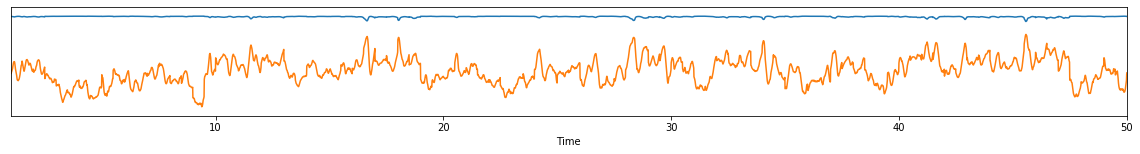

In [176]:
scd_scores

# Final segmentation ( an overlay of SAD and SCD)

In [177]:
# speech turns are simply the intersection of SAD and SCD
speech_turns = partition.crop(speech)

Visualize the results

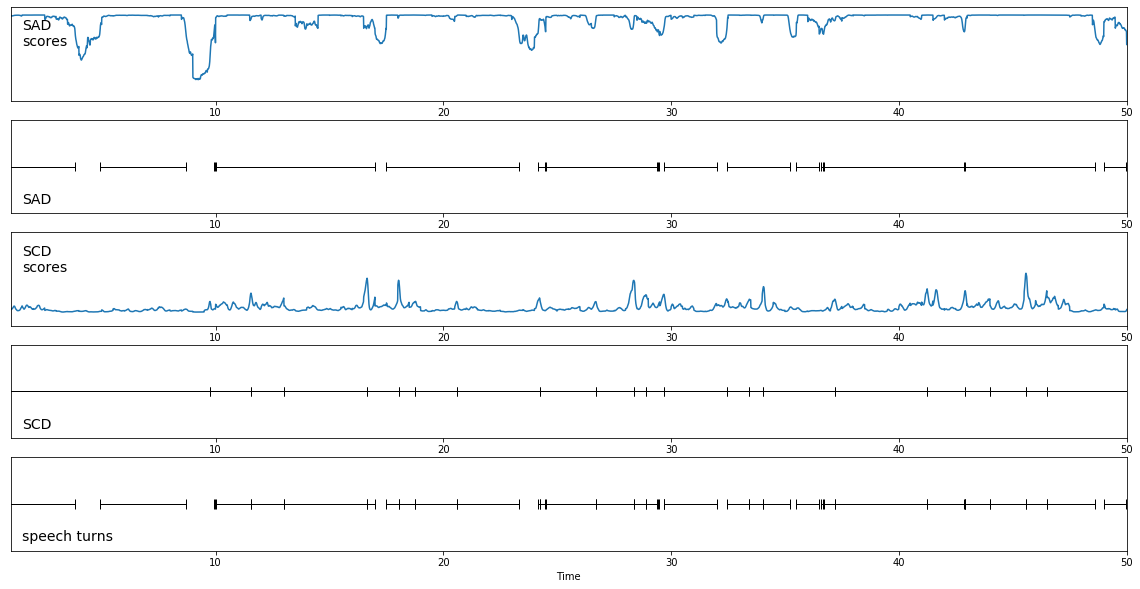

In [180]:
# let's visualize SAD and SCD results using pyannote.core visualization API
from matplotlib import pyplot as plt
import numpy as np
from pyannote.core import Segment, notebook

# only plot one minute (between t=120s and t=180s)
notebook.crop = Segment(1,50)
# helper function to make visualization prettier
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)

# create a figure with 6 rows with matplotlib
nrows = 5
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)



# 2nd row: SAD raw scores
notebook.plot_feature(plot_ready(sad_scores), ax=ax[0])
ax[0].text(notebook.crop.start + 0.5, 0.6, 'SAD\nscores', fontsize=14);
ax[0].set_ylim(-0.1, 1.1)

# 3rd row: SAD result
notebook.plot_timeline(speech, ax=ax[1])
ax[1].text(notebook.crop.start + 0.5, 0.1, 'SAD', fontsize=14);

# 4th row: SCD raw scores
notebook.plot_feature(plot_ready(scd_scores), ax=ax[2])
ax[2].text(notebook.crop.start + 0.5, 0.3, 'SCD\nscores', fontsize=14);
ax[2].set_ylim(-0.1, 0.6)

# 5th row: SCD result
notebook.plot_timeline(partition, ax=ax[3])
ax[3].text(notebook.crop.start + 0.5, 0.1, 'SCD', fontsize=14);

# 6th row: combination of SAD and SCD
notebook.plot_timeline(speech_turns, ax=ax[4])
ax[4].text(notebook.crop.start + 0.5, 0.1, 'speech turns', fontsize=14);

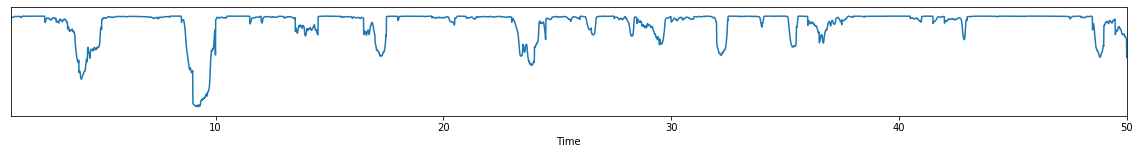

In [141]:
plot_ready(sad_scores)

# Extract embeddings:

In [142]:
# initialize sequence embedding model
from pyannote.audio.embedding.extraction import SequenceEmbedding
emb = SequenceEmbedding(model=EMB_MODEL, duration=1., step=0.5)

# obtain raw embeddings (as `pyannote.core.SlidingWindowFeature` instance)
# embeddings are extracted every 500ms on 1s-long windows
embeddings = emb(test_file)

/home/geoanton/anaconda3/envs/pyannote/lib/python3.6/site-packages/pyannote/audio/applications/base.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config_ = yaml.load(fp)


In [143]:
# for the purpose of this tutorial, we only work of long (> 2s) speech turns
from pyannote.core import Timeline
long_turns = Timeline(segments=[s for s in speech_turns if s.duration > 2.])

In [144]:
X, Y = [], []
for segment in long_turns:
    # "strict" only keeps embedding strictly included in segment
    x = embeddings.crop(segment, mode='strict')
    # average speech turn embedding
    X.append(np.mean(x, axis=0))

    # keep track of speaker label (for later scatter plot)
    y = 0
    Y.append(y)

X = np.vstack(X)
_, y_true = np.unique(Y, return_inverse=True)

# TSNE visualization

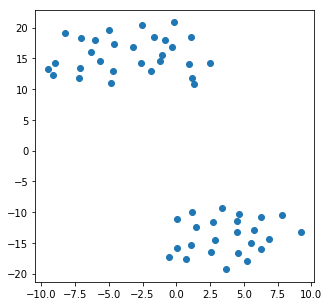

In [171]:
# apply tSNE on embeddings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, metric="cosine",n_iter=6050,perplexity=10,learning_rate=50)
pc = PCA()
X_2d = tsne.fit_transform(X)
X_pc = pc.fit_transform(X)

# plot 
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
plt.scatter(*X_2d.T)

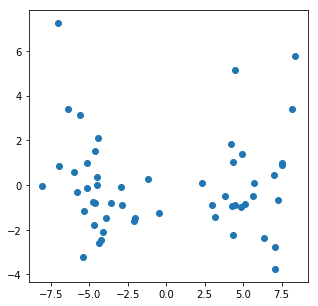

In [146]:
# plot 
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
plt.scatter(*X_pc[:,0:2].T)

array([0.52863884, 0.61442965, 0.68878293, 0.7416429 , 0.7829485 ,
       0.8215747 , 0.84632725, 0.8692171 , 0.8883544 , 0.90527886,
       0.91961753, 0.93113893, 0.9408542 , 0.9485886 , 0.9549235 ,
       0.960427  , 0.96525306, 0.9698089 , 0.97379124, 0.97710454,
       0.9796723 , 0.98206   , 0.9841319 , 0.985875  , 0.98747736,
       0.9888094 , 0.99000496, 0.9910968 , 0.9920841 , 0.99301386,
       0.9937636 , 0.9944928 , 0.9951016 , 0.99565446, 0.9961614 ,
       0.996641  , 0.9970903 , 0.997483  , 0.9978387 , 0.99815404,
       0.99845994, 0.99873084, 0.99898875, 0.99920946, 0.9994094 ,
       0.9995785 , 0.99973446, 0.9998749 , 0.9999999 , 0.9999999 ],
      dtype=float32)